<a href="https://colab.research.google.com/github/bavin342/Data-Science/blob/main/CQF_LSTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are going to use LSTM to predict stock movement. This is going to be a classifcation problem, i.e if the stock price goes up then we classify it as 1, if it goes down then we classify it as 0. 

We are going to be using netflix data.



In [89]:
# Imports
!pip install yfinance 
!pip install keras-tuner --upgrade
import seaborn as sns
import math
import pandas as pd
import numpy as np 
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
import time
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras_tuner as kt
from keras_tuner import HyperParameter, HyperParameters
from keras_tuner import BayesianOptimization, RandomSearch, Hyperband
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

!pip install -U git+https://github.com/twopirllc/pandas-ta

  Cloning https://github.com/twopirllc/pandas-ta to /tmp/pip-req-build-bpbc46m_
  Running command git clone -q https://github.com/twopirllc/pandas-ta /tmp/pip-req-build-bpbc46m_


In [102]:
# Functions Script

def get_plot(df, x_column: str, y_column: str, title: str):

    plt.figure(figsize = (18,9))
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title('{}'.format(title))
    return plt.plot(df[y_column], 
                    "-b", 
                    label = '{}'.format(y_column)), plt.legend('{} Price'.format(y_column)) 


def PE(symbol: str):
    data = yf.Ticker(symbol).info
    return (data["trailingPE"], data["forwardPE"])


def class_ratio(df_work):
    df = df_work.copy()

    df = Features.get_target(df)
    df = df[['target']]
    class_check = df.value_counts()
    return class_check

def check_NA(data, 
            ):
    df = data.copy()
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print('{} had {} null values'.format(col, df[col].isnull().sum()))
    for i in df:
        print("Cleaned df is given below")
        df = df.dropna(axis=1, how="any", thresh=None, subset=None, inplace=False)
        return df


def get_full_df(df):
    df = df_work.copy()
    
    df = Features.get_log_return(df)
    rsi_df = Features.get_rsi(df.Close, 14)
    df = df.merge(rsi_df, how = 'inner', on = 'Date').reset_index()
    df = Features.get_CCI(df, 14)
    df = Features.get_SO(df)
    df = Features.get_SMA(df)
    df = Features.get_ATR(df)
    df = Features.get_Momentum(df,20)
    df = Features.get_EMA(df)
    df = Features.get_VWAP(df)
    df = Features.get_target(df)
    df = df.dropna().reset_index(drop=True)
    return df


def target_df(df_work):
    df = df_work.copy()
    df = Features.get_target(df)
    return df[df['target']]



def get_features_df(df_work):
    df = df_work.copy()

    df = Features.get_log_return(df)
    rsi_df = Features.get_rsi(df.Close, 14)
    df = df.merge(rsi_df, how = 'inner', on = 'Date').reset_index()
    df = Features.get_CCI(df, 14)
    df = Features.get_SO(df)
    df = Features.get_SMA(df)
    df = Features.get_ATR(df)
    df = Features.get_Momentum(df,20)
    df = Features.get_EMA(df)
    df = Features.get_VWAP(df)
    df = Features.get_target(df)
    df = df.dropna().reset_index(drop=True)
    features_df = df.drop(['target'],axis=1)
    features_df = features_df.set_index('Date')
    return features_df

In [91]:
class Features:
    " A class for all the features used which will be parsed into the LSTM for our classification problem "
    
    def get_log_return(df):
      df['return'] = np.log(df.Close).diff().fillna(0)
      return df


    # def get_YZ_vol(df, lookback=10):
    #     o = df.Open
    #     h = df.High
    #     l = df.Low
    #     c = df.Close
        
    #     k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    #     cc = np.log(c/c.shift(1))
    #     ho = np.log(h/o)
    #     lo = np.log(l/o)
    #     co = np.log(c/o)
    #     oc = np.log(o/c.shift(1))
    #     oc_sq = oc**2
    #     cc_sq = cc**2
    #     rs = ho*(ho-co)+lo*(lo-co)
    #     close_vol = pd.rolling().sum(cc_sq, window=lookback) * (1.0 / (lookback - 1.0))
    #     open_vol = pd.rolling().sum(oc_sq, window=lookback) * (1.0 / (lookback - 1.0))
    #     window_rs = pd.rolling().sum(rs, window=lookback) * (1.0 / (lookback - 1.0))
    #     result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    #     result[:lookback-1] = np.nan
    #     return result * 100

    def get_rsi(close, lookback):
        ret = close.diff()
        up = []
        down = []
        for i in range(len(ret)):
            if ret[i] < 0:
                up.append(0)
                down.append(ret[i])
            else:
                up.append(ret[i])
                down.append(0)
        up_series = pd.Series(up)
        down_series = pd.Series(down).abs()
        up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
        down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
        rs = up_ewm/down_ewm
        rsi = 100 - (100 / (1 + rs))
        rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
        rsi_df = rsi_df.dropna()
        return rsi_df


    def get_CCI(df, ndays):
        df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3 
        df['sma'] = df['TP'].rolling(ndays).mean()
        df['mad'] = df['TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
        df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
        df = df.drop(['TP', 'sma', 'mad'], axis=1)
        df = df.dropna() 
        return df

    def get_SO(df):
        df['14-high'] = df['High'].rolling(14).max()
        df['14-low'] = df['Low'].rolling(14).min()
        df['%K'] = (df['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
        df['%D'] = df['%K'].rolling(3).mean()
        df = df.drop(['14-high', '14-low'], axis=1)
        df = df.dropna()
        return df


    def get_SMA(df, period=30,column='Close'):
        df['SMA'] = df[column].rolling(window=period).mean()
        df = df.dropna()
        return df
    
    def get_ATR(df, period=14):
        high_low = df['High'] - df['Low']
        high_cp = np.abs(df['High'] - df['Close'].shift())
        low_cp = np.abs(df['High'] - df['Close'].shift())
        tr=pd.concat([high_low, high_cp, low_cp], axis=1) 
        true_range = np.max(tr, axis=1)
        df['ATR'] = true_range.rolling(window=period).mean()
        df = df.dropna()
        return df
        
    def get_Momentum(df, n):
        M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
        df = df.join(M)
        df = df.dropna()
        return df
    
    def get_EMA(df):
        df['EMA'] = df['Close'].ewm(span=14).mean()
        return df
        
    def get_VWAP(df):
        df['VWAP'] = (df.Volume * (df.High + df.Low) / 2).cumsum() / df.Volume.cumsum()
        return df

    
    def get_target(df):
      df['target'] = df['Close'] - df['Close'].shift(-1)
      df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
      return df

In [ ]:
class FS:

    def __init__(self, df):
        self.df = df


    def get_

SyntaxError: ignored

Building a class for all the features we are going to use for our LSTM

In [ ]:
class LSTM:
  
  ""A Keras tuner for LSTM classifier""

    def get_



    def get_


    def get_

    def get_

In [103]:
# Get the data via yahoo finance
yf.pdr_override()
start = datetime.datetime(2007, 1, 1)
end = datetime.datetime(2022, 1, 1)

df = pdr.get_data_yahoo('NFLX', start, end) # Data for Netflix inc
display(df), get_plot(df,'Date', 'Close', 'Netflix Stock Price')

AttributeError: ignored

In [104]:
features = get_features_df(df)
features.dtypes

Open           float64
High           float64
Low            float64
Close          float64
Adj Close      float64
Volume           int64
return         float64
rsi            float64
CCI            float64
%K             float64
%D             float64
SMA            float64
ATR            float64
Momentum_20    float64
EMA            float64
VWAP           float64
dtype: object

Checking if any missing values (NaN) are dropped

In [105]:
np.isnan(features.any()).sum()

0

**Elbow Plot**

In [106]:
# Import sklearn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# import yfinance as yf
from datetime import datetime

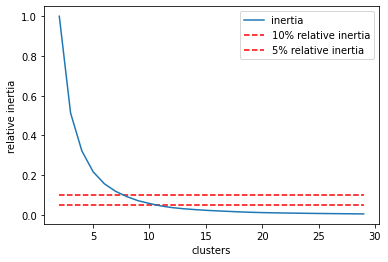

In [107]:
n_clusters = range(2, 30)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, np.divide(inertia,inertia[0]))
plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);

We can deduce that we want to reduce our features to around 10, as thats where the line sits below the 5% relative inertia level. 

In [110]:
# Manipulate dataframe: drop and resample
daily_stock = features.resample('M').last()
daily_stock = daily_stock.T

# Check output
daily_stock.head()

Date,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,...,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31
Open,3.142857,2.867143,2.528571,2.478571,3.057143,3.782857,3.364286,3.850000,3.221429,4.547143,...,515.669983,505.000000,504.399994,534.059998,512.690002,566.119995,608.049988,673.059998,668.200012,610.010010
High,3.182857,2.881429,2.528571,2.511429,3.085714,3.787143,3.420000,3.897143,3.621429,4.571429,...,528.130005,514.549988,511.760010,534.380005,519.789978,569.479980,619.000000,690.969971,675.380005,614.080017
Low,3.124286,2.765714,2.442857,2.450000,2.950000,3.682857,3.224286,3.701429,3.158571,4.302857,...,515.440002,505.000000,502.529999,526.820007,510.959991,561.609985,608.049988,671.239990,640.010010,602.049988
Close,3.128571,2.770000,2.461429,2.502857,2.964286,3.781429,3.300000,3.802857,3.592857,4.511429,...,521.659973,513.469971,502.809998,528.210022,517.570007,569.190002,610.340027,690.309998,641.900024,602.440002
Adj Close,3.128571,2.770000,2.461429,2.502857,2.964286,3.781429,3.300000,3.802857,3.592857,4.511429,...,521.659973,513.469971,502.809998,528.210022,517.570007,569.190002,610.340027,690.309998,641.900024,602.440002


**Build Clusters**

In [111]:
# Normalize and fit the model
pipe = Pipeline([("normalization", MinMaxScaler()), ("cluster", KMeans(n_clusters=16))])

In [112]:
# Fit Model
pipe.fit(daily_stock)

# Assign Label
labels = pipe.predict(daily_stock)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


In [118]:
len(labels), len(indicators)

(16, 16)

In [115]:
labels

array([ 2, 13, 14, 12, 12,  1, 11,  0,  4,  7,  9,  8,  3,  6, 10,  5],
      dtype=int32)

In [120]:
df2 = pd.DataFrame({ 'Clusters': labels, 
                      'Features': indicators}
                      ).sort_values(by=['Clusters'], axis=0)

cluster_df = df2.reset_index(drop=True)
cluster_df

,Clusters,Features
0,0,rsi
1,1,Volume
2,2,Open
3,3,ATR
4,4,CCI
5,5,VWAP
6,6,Momentum_20
7,7,%K
8,8,SMA
9,9,%D


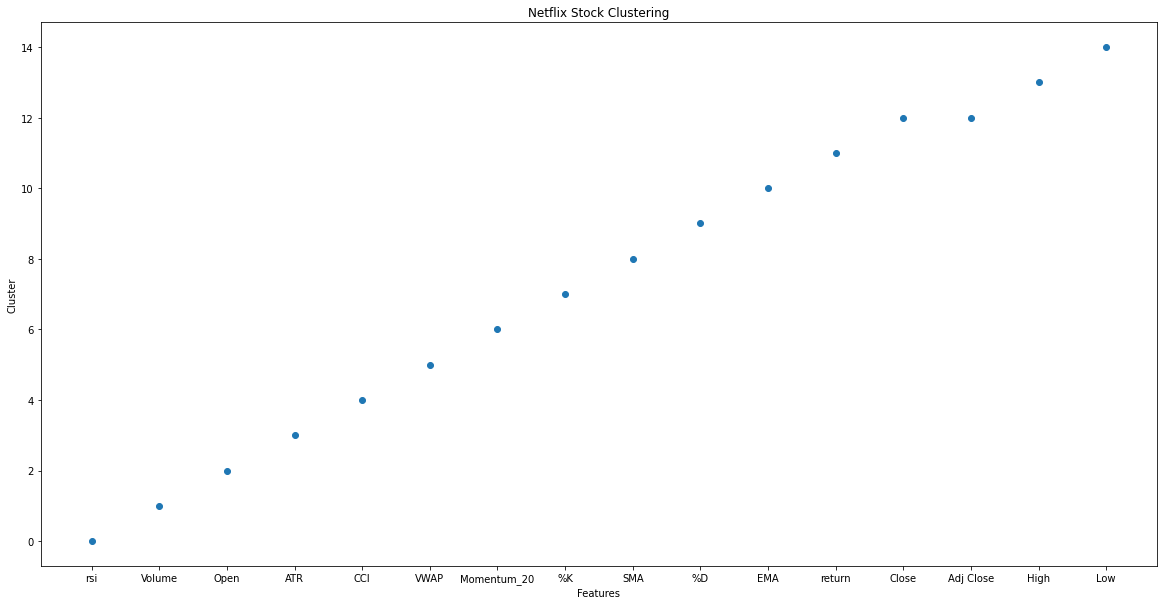

In [122]:
plt.figure(figsize=(20,10))
plt.scatter(cluster_df.Features, cluster_df.Clusters)
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.title('Netflix Stock Clustering');

In [123]:
pipe.get_params()

{'cluster': KMeans(n_clusters=16),
 'cluster__algorithm': 'auto',
 'cluster__copy_x': True,
 'cluster__init': 'k-means++',
 'cluster__max_iter': 300,
 'cluster__n_clusters': 16,
 'cluster__n_init': 10,
 'cluster__random_state': None,
 'cluster__tol': 0.0001,
 'cluster__verbose': 0,
 'memory': None,
 'normalization': MinMaxScaler(),
 'normalization__clip': False,
 'normalization__copy': True,
 'normalization__feature_range': (0, 1),
 'steps': [('normalization', MinMaxScaler()),
  ('cluster', KMeans(n_clusters=16))],
 'verbose': False}

In [124]:
pipe['cluster'].cluster_centers_

array([[9.72528020e-06, 8.42411014e-06, 9.47112288e-06, ...,
        1.92763908e-05, 2.41907335e-05, 2.77560332e-05],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.90962151e-06, 5.33485122e-06, 5.91308570e-06, ...,
        1.75943368e-04, 1.35672918e-04, 3.12658746e-04],
       ...,
       [3.91531301e-06, 5.33603343e-06, 5.91308570e-06, ...,
        1.80625347e-04, 1.36953004e-04, 3.14697916e-04],
       [3.90697907e-06, 5.32645767e-06, 5.90420753e-06, ...,
        1.75467586e-04, 1.30647060e-04, 3.08670587e-04],
       [6.25042027e-02, 6.25049873e-02, 6.25057436e-02, ...,
        6.25859012e-02, 6.25671187e-02, 6.26480276e-02]])

In [125]:
pipe['cluster'].cluster_centers_.shape

(16, 176)

In [196]:
#Save locally to be used in SOM
cluster_df.to_csv('data/cluster.csv')

Checking Class Imbalance 

In [ ]:
class_ratio(df)

target
0         1939
1         1838
dtype: int64

There is about 100 more class 0 samples, however because there are almost somewhat equal, and not heavily imbalanced, I will not aim to do oversampling/undersampling. 

# **Feature Selection**

This section we will be doing feature selection and see what features are most effecitve for our model. This part of the code will also contain, feature engineering and transfomation. 

In [169]:
# Split the data from 2015
df_train = features[features.index <= datetime(2014,1,1)]
df_test  = features[features.index > datetime(2015,1,1)]

In [170]:
# Define train and test with two features
X_train = df_train[['Close','ATR']]
X_test = df_test[['Close','ATR']]

K - Means Cluster Algo 

- Here we are trying to find the optimal number of features needed for the model as the number of features (clusters) is a hyperparameter. 


In [171]:
# Training with 8 clusters
kmeans = KMeans(n_clusters=8).fit(X_train)
df_train['Target']  = kmeans.predict(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


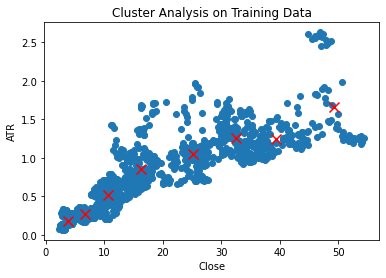

In [174]:
# Train plot
centers = kmeans.cluster_centers_
plt.scatter(X_train['Close'], X_train['ATR']),
plt.scatter(centers[:,0], centers[:,1], c='red', s=100, marker='x')
plt.xlabel('Close')
plt.ylabel('ATR')
plt.title('Cluster Analysis on Training Data')
plt.show()


  **Testing**

In [175]:
df_test['Target']  = kmeans.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


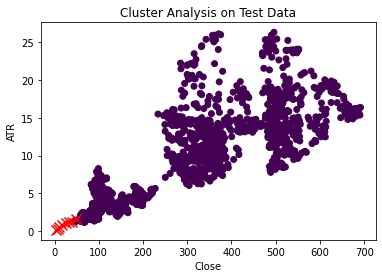

In [178]:
# Test plot
centers = kmeans.cluster_centers_
plt.scatter(X_test['Close'], X_test['ATR'], c=df_test['Target'])
plt.scatter(centers[:,0],centers[:,1], c='red', s=100, marker='x')
plt.xlabel('Close')
plt.ylabel('ATR')
plt.title('Cluster Analysis on Test Data')
plt.show()

In [179]:
features

,Open,High,Low,Close,Adj Close,Volume,return,rsi,CCI,%K,%D,SMA,ATR,Momentum_20,EMA,VWAP,Target
Date,,,,,,,,,,,,,,,,,
2007-05-15,3.134286,3.148571,3.088571,3.107143,3.107143,4726400,-0.009609,39.401832,-149.461529,17.360954,32.948057,3.255143,0.069694,-0.315714,3.107143,3.118571,0
2007-05-16,3.108571,3.141429,3.031429,3.102857,3.102857,5036500,-0.001380,38.998516,-180.612349,29.069599,27.869984,3.245333,0.069796,0.002857,3.104847,3.101990,0
2007-05-17,3.081429,3.140000,3.074286,3.117143,3.117143,5142200,0.004594,41.160506,-101.827758,34.883597,27.104717,3.232429,0.070918,0.044286,3.109544,3.103767,0
2007-05-18,3.121429,3.144286,3.101429,3.134286,3.134286,4446400,0.005485,43.737421,-51.447906,41.860413,35.271203,3.221667,0.070918,-0.022857,3.117113,3.108154,0
2007-05-21,3.130000,3.234286,3.122857,3.214286,3.214286,6663300,0.025204,53.886902,95.227308,74.418663,50.387558,3.212905,0.074082,0.110000,3.142466,3.126190,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,615.000000,615.000000,609.250000,613.119995,613.119995,2061500,-0.001581,46.207667,39.987688,61.869056,63.242627,633.188334,13.797141,-52.520020,611.112988,76.968868,0
2021-12-28,614.950012,618.409973,609.690002,610.710022,610.710022,1882800,-0.003938,45.155476,50.956376,57.117535,60.922723,630.791669,13.170711,-53.130005,611.059259,76.984453,0
2021-12-29,610.710022,613.979980,604.679993,610.539978,610.539978,1287200,-0.000278,45.077480,42.507785,59.381418,59.456003,628.498667,13.173567,-31.360046,610.990022,76.995014,0


In [189]:
# Output the results
print("Total Points Earned by Cluster Prediction: Training & Testing")
print('Cluster 1 Train : {}'.format(df_train['return'].loc[df_train.Target==0].sum())), 'Cluster 1 Train : {}'.format(df_train['return'].loc[df_train.Target==0].sum())
print('Cluster 2 Train : {}'.format(df_train['return'].loc[df_train.Target==2].sum())), 'Cluster 2 Train : {}'.format(df_train['return'].loc[df_train.Target==2].sum())
print('Cluster 3 Train : {}'.format(df_train['return'].loc[df_train.Target==3].sum())), 'Cluster 3 Train : {}'.format(df_train['return'].loc[df_train.Target==3].sum())

Total Points Earned by Cluster Prediction: Training & Testing
Cluster 1 Train : 0.2099099201758794
Cluster 2 Train : 0.5996629109550828
Cluster 3 Train : 0.33665413908535013


(None, 'Cluster 3 Train : 0.33665413908535013')

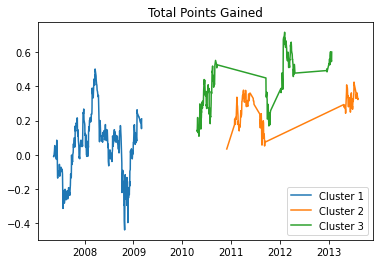

In [192]:
plt.plot(np.cumsum(df_train['return'].loc[df_train['Target'] == 0]),label='Cluster 1')
plt.plot(np.cumsum(df_train['return'].loc[df_train['Target'] == 1]),label='Cluster 2')
plt.plot(np.cumsum(df_train['return'].loc[df_train['Target'] == 2]),label='Cluster 3')
plt.title('Total Points Gained')
plt.legend()
plt.show()

# SOM (Self Organising Map)



In [201]:
# Read cluster file saved locally
som = pd.read_csv('data/cluster.csv', index_col=0)
som

,Clusters,Features
0,0,rsi
1,1,Volume
2,2,Open
3,3,ATR
4,4,CCI
5,5,VWAP
6,6,Momentum_20
7,7,%K
8,8,SMA
9,9,%D


Define a Feature Matrix

In [200]:
# Define feature matrix
X = df[['ATR', 'CHG']]

# Transfor feature matrix
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

KeyError: ignored